# Using NLP to Flag Political Reddit Posts

Reddit.com is a aggregation website for a wide variety of forums, called subreddits. One of the most popular aspects of Reddit is it's upvote/downvote system. This voting system allows the community to self-moderate, but only to a certain extent. As Reddit has grown in popularity and size over the years the need for dedicated moderation has grown.

For Reddit moderators to effectively work they use a variety of tools. This project is to make another tool for them: a flagging system that identifies posts that are political.

**The goal of this project is to make a model that accurately flags AskReddit posts that are political in nature.** To do this I will use NLP to classify posts into either AskReddit or Poltics. If a post on AskReddit is identified as belonging in Politics it would be flagged and sent to the moderator.

### Read in Data

In [3]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [4]:
#read in dataframes that were preapred in data_collection.ipynb
ar_df = pd.read_csv('./data/askredditcopy.csv', index_col = 'Unnamed: 0')
pol_df = pd.read_csv('./data/politicscopy.csv', index_col = 'Unnamed: 0')

In [5]:
#add these dataframes together to create the dataframe to be used for modeling
df = pd.concat([ar_df, pol_df], axis = 0)

In [6]:
#binarize subreddit column
df['is_pol'] = df['subreddit'].map({'politics': 1, 'AskReddit': 0})
df.drop(columns = 'subreddit', inplace = True)

In [7]:
#check shape of dataframe
df['is_pol'].value_counts()

1    3000
0    3000
Name: is_pol, dtype: int64

In [8]:
df.head()

,title,is_pol
0,Would you be willing to donate to someone who ...,0
1,What's the most memorable thing you've seen on...,0
2,Who do you follow? At this point in my life I ...,0
3,"Colorblind people on Reddit, what was the last...",0
4,What did you do recently that took courage?,0


In [9]:
X = df['title']
y = df['is_pol']

#train test split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

### Define functions

In [10]:
#these functions are used for all three models
def score_model(gs_name):
    '''Prints the best score, the best parameters, the training score, and the testing score of the input gridsearch '''
    print('GS Best Score:', gs_name.best_score_)
    print('GS Best Params:', gs_name.best_params_)
    print('Training Score:', gs_name.score(X_train, y_train))
    print('Testing Score:', gs_name.score(X_test, y_test))
  
def create_confusion_matrix(gs_name):
    '''Plots a confusion matrix for a binary classification gridsearch'''
    # Get predictions
    preds = gs_name.predict(X_test)
    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    plot_confusion_matrix(gs_name, X_test, y_test, cmap='Blues', values_format='d');
    
def flagged_ar_posts_to_csv(gs_name, model_name):
    '''Exports to csv whichever AskReddit posts the input model flagged as political'''
    preds_ar = gs_name.predict(ar_df['title'])
    ar_df['predicted'] = preds_ar
    predicted_political_ar = ar_df[ar_df['predicted'] == 1]
    predicted_political_ar.to_csv(f"./results/results_{model_name}.csv")

# Model Using Count Vectorizer, Naive Bayes

In [11]:
#create pipeline
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

#parameter dictionary used for gridsearch
pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

#search for optimal parameters in parameter dictionary
gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5) 

gs.fit(X_train, y_train)

score_model(gs)

GS Best Score: 0.9634328358208956
GS Best Params: {'cvec__max_df': 0.9, 'cvec__max_features': 4000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}
Training Score: 0.9746268656716418
Testing Score: 0.9555555555555556


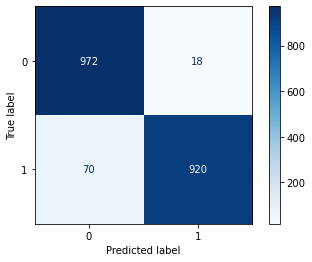

In [12]:
create_confusion_matrix(gs)
flagged_ar_posts_to_csv(gs, model_name = 'cv')

In the confusion matrix above we see that only 18 of the 1000 askreddit posts in the testing set were flagged as being political. Of all 3000, the csv file in the results folder has the 29 that were classified as political. Of those 29, only 9 are clearly political.

Since this model is designed to save moderators time, it's generally better to "miss" political posts (also known as false negatives) than it is to flag posts that are not political (also known as false positives). This is becasuse flagging too many posts would be difficult for moderators to read through.

One problem with this model is we do not know the number of "missed" poltical posts. Without actually reading through all 3000 posts we can't know the true number of political posts in the dataset. Without reading through all 3000 posts the best we can do is calculate the percentage of flagged posts that are actually political. And in this case it is 9 out of 29, or 31.0%.

# Model Using TFIDF Vectorizer, Naive Bayes

In [13]:
#create pipeline
pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

#parameter dictionary used for gridsearch
pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

#search for optimal parameters in parameter dictionary
gs_tvec = GridSearchCV(pipe_tvec, # what object are we optimizing?
                        param_grid = pipe_tvec_params, # what parameters values are we searching?
                        cv=5) # 5-fold cross-validation.

gs_tvec.fit(X_train, y_train)

score_model(gs_tvec)

GS Best Score: 0.9599502487562189
GS Best Params: {'tvec__max_features': 4000, 'tvec__ngram_range': (1, 2), 'tvec__stop_words': None}
Training Score: 0.9743781094527363
Testing Score: 0.9545454545454546


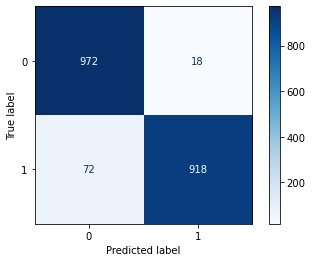

In [14]:
create_confusion_matrix(gs_tvec)
flagged_ar_posts_to_csv(gs_tvec, model_name = 'tvec')

The results of this TFIDF model are very similar to the Count Vectorizer model. The testing score is lower, meaning that about .1% more posts are classifed into the wrong subreddit.

The number of flagged posts is very low once again. Only 26 of the 3000 posts in the dataet were flagged. And almost all of them are contained in the flagged posts of the first model.

Considering the lower testing score and the lack of advantages over the first model it's safe to say that the Count Vectorizer model remains our best for this purpose.

# Model Using Count Vecotrizer, Logistic Regression

In [15]:
#create pipeline
pipe_log = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

#parameter dictionary used for gridsearch
pipe_log_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

#search for optimal parameters in parameter dictionary
gs_log = GridSearchCV(pipe_log, # what object are we optimizing?
                  param_grid=pipe_log_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

gs_log.fit(X_train, y_train)

score_model(gs_log)

GS Best Score: 0.9634328358208956
GS Best Params: {'cvec__max_df': 0.9, 'cvec__max_features': 2000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 2)}
Training Score: 0.9885572139303482
Testing Score: 0.953030303030303


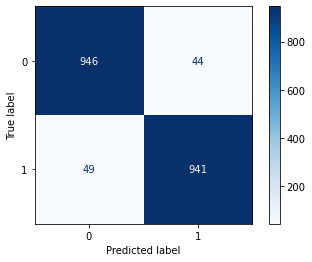

In [16]:
create_confusion_matrix(gs_log)
flagged_ar_posts_to_csv(gs_log, model_name = 'log')

The testing score of the logistic regresion model is about .2% lower than our previous best, the Count Vectorizer model. The testing score of this model is the highest of the three, indicating that the logistic regression model is more overfit than other models.

The major difference between the logistic regression model and the other models is that more posts were flagged. Without reading the flagged posts we do not know if that is good or bad. After all, the goal is to flag political posts, not classify posts into the correct subreddit.

Out of all 3000 posts in the dataset this model flagged 75 of them. Of those 75 only 15 are political. That comes out to a correct flag rate of 20.0%, compared to 31.0% for the Count Vectorizer model. Depending on how fast we can process flagged posts it might be advisable to use this model because it flags more posts even though it has a lower correct flag rate.

## Conclusion

In this project I set out to identify and flag for removal AskReddit posts that are political in nature. Therefore the success of these models is measured by what percentage of flagged AskReddit posts are political. 

The advantage of these models was a high testing score. About 95% of posts were correclty classfied into the subreddit where they were submitted. It follows that a model with this degree of accuracy would be able to predict which posts do not belong in the subreddit where they were posted.

There are several areas for futher development in this project. For one, we do not know how many political posts were in the entire dataset. That makes us unable to measure how many political posts were not flagged. When doing my EDA I did see that the number of political posts in the dataset appeared to be very low. It would be better to conduct this analysis with posts during a more political time such as shortly before a presidential election.

Another weakness of this analysis is that upvotes and downvotes were ignored. It would be better to do this analysis only on posts with 50 upvotes or above. Ignoring the voting system made a lot of the dataset low-effort spam posts or childish in nature. Only putting posts with 50+ upvotes into the model would be a better use of moderator time. It would ensure they are only worrying about posts that are likely to get signifigant visibility.

In conclusion, these models were effective at classifying posts to the subreddit where they were posted. But to use them as a moderation tool we would want to increase the correct flag rate.

In [ ]:

en_params = { 